<a href="https://colab.research.google.com/github/JoseTobon/AI_Notebooks/blob/main/CalistaAesthetics_AP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calista-AI Approach 2 - MobileNet**
Usage of pretrained models

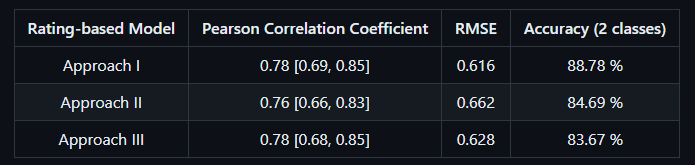


In [7]:
# Cloning of repo
!git clone https://github.com/calista-ai/website-aesthetics-research.git

# Downloading of datasets
!cd website-aesthetics-research/ && git submodule update --init

fatal: destination path 'website-aesthetics-research' already exists and is not an empty directory.
Cloning into '/content/website-aesthetics-research/datasets'...
Submodule path 'datasets': checked out '276babac8308628f47e17d6e64feda9f23d89276'


## **Rating-based approach II**

Description: In this approach, the model was trained using the mean value of the user ratings for each website. The model's output is an aesthetics score on the scale 1-9.

Transfer-learning: Flickr-Style was used as a base network

In [8]:
# Get Gdown for downloading large drive files
!pip install gdown
# Donwload of pretrained model based on approach 1

!cd website-aesthetics-research/pretrained-models/ && gdown https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT -O flickr_style.h5

Downloading...
From (original): https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT
From (redirected): https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT&confirm=t&uuid=a1414043-99d6-4f25-918a-e12ee66d84ef
To: /content/website-aesthetics-research/pretrained-models/flickr_style.h5
100% 228M/228M [00:01<00:00, 121MB/s]


In [9]:
# Installation of dependencies
!pip install -r website-aesthetics-research/requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.14.0


In [10]:
!pip install unrar
!unrar x 'website-aesthetics-research/datasets/rating-based-dataset/data/ae_only_unambiguous_1000.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from website-aesthetics-research/datasets/rating-based-dataset/data/ae_only_unambiguous_1000.rar

Extracting  ae_only_unambiguous_1000.csv                                   0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 9

Import training and testing data.

{train, test}_images: contains the path of each image

{train, test}_scores: contains the user ratings of each image

In [11]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

data_folder = 'website-aesthetics-research/datasets/rating-based-dataset/'

scores_data = pd.read_csv("ae_only_unambiguous_1000.csv", low_memory=False)

_images = scores_data['website'].unique()
_scores = scores_data.groupby('website')['mean_response'].apply(list)

del scores_data

all_images = []
scores = []
images_path = data_folder + 'preprocess/resized'

for image in _images:

  # english websites
  if 'english' in image:
    all_images.append(images_path + '/english_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

  # foreign websites
  if 'foreign' in image:
    all_images.append(images_path + '/foreign_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

print('Total number of images: %d' % len(all_images))


test_data_path = data_folder + 'preprocess/test_list.csv'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)

    return (images, scores)

test_images_names, gt_scores = get_scores(test_data_path)

train_images =[]
train_scores =[]

test_images = test_images_names
test_scores = [[]] * len(test_images)

for i in range(0, len(all_images)):
  if all_images[i] in test_images_names:

    pos = test_images_names.index(all_images[i])

    test_scores[pos] = scores[i]
  else:
    train_images.append(all_images[i])
    train_scores.append(scores[i])

Total number of images: 398


In [12]:
# Shuffle the training data

import random

# np.random.seed(2000)

temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)

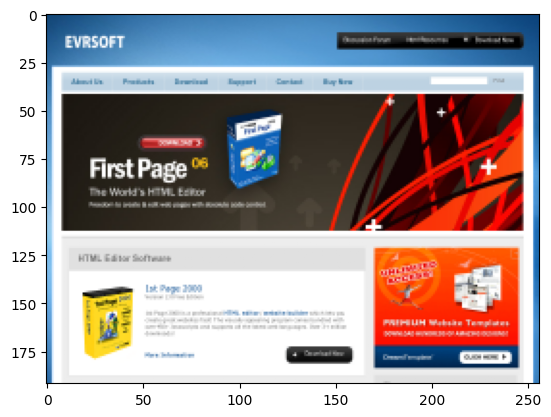

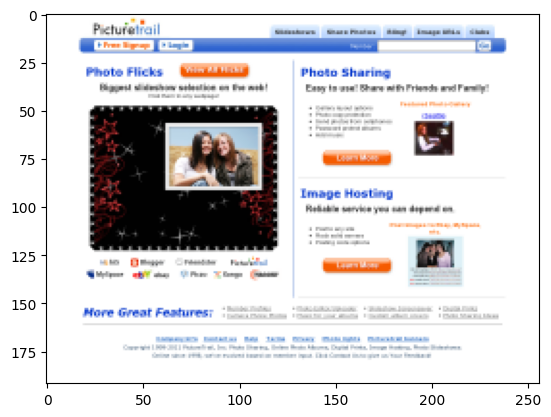

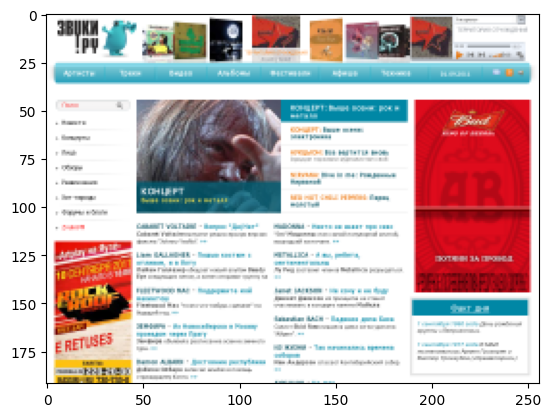

In [13]:
# Displaying images

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
  img = mping.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

In [14]:
# Transform to numpy arrays

import cv2

width = 256
height = 192
channels = 3

def read_and_process_images(list_of_images):
  X = []

  for image in list_of_images:

    #images are already resized
    #X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height),
                         #interpolation=cv2.INTER_AREA))
    X.append(cv2.imread(image, cv2.IMREAD_COLOR))


  return X


X_train = np.array(read_and_process_images(train_images))
X_val = np.array(read_and_process_images(test_images))

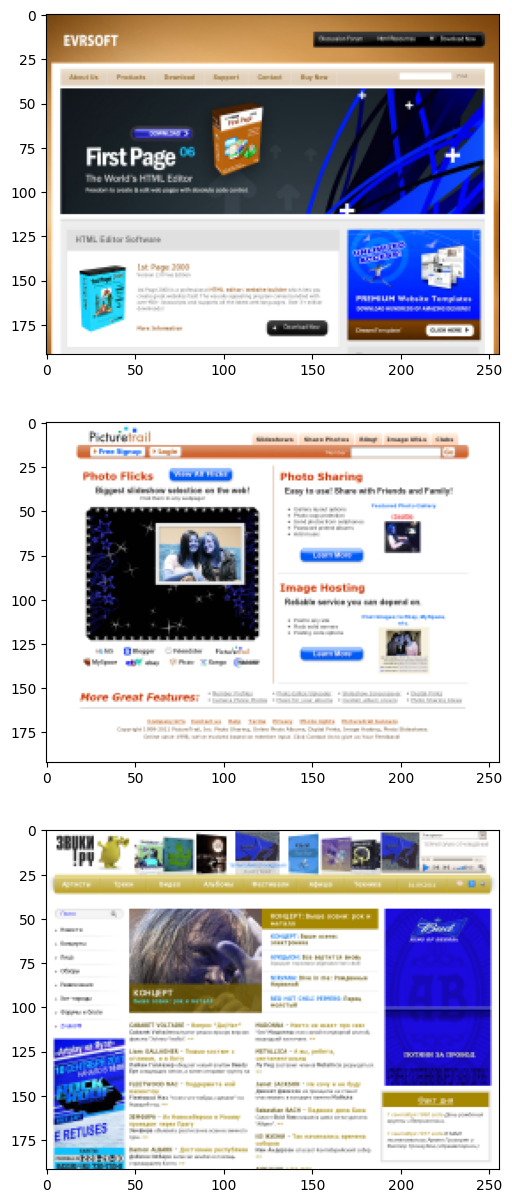

In [15]:
plt.figure(figsize=(25,15))
columns = 3

for i in range(columns):
  plt.subplot(columns, 1, i+1)
  plt.imshow(X_train[i])

In [16]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
score_values = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

y_train = []

for i in range(0, len(train_scores)):
  y_temp = np.histogram(train_scores[i], bins=bins)[0]
  y_train.append(y_temp / len(train_scores[i]))
  del y_temp

y_train = np.array(y_train)

y_val = []

for i in range(0, len(test_scores)):
  y_temp = np.histogram(test_scores[i], bins=bins)[0]
  y_val.append(y_temp / len(test_scores[i]))
  del y_temp

y_val = np.array(y_val)


In [17]:
ntrain = len(X_train)
nval = len(X_val)

print('Shape of X_train is: ', X_train.shape)
print('Shape of X_val is: ', X_val.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of y_val is: ', y_val.shape)

Shape of X_train is:  (300, 192, 256, 3)
Shape of X_val is:  (98, 192, 256, 3)
Shape of y_train is:  (300, 9)
Shape of y_val is:  (98, 9)


Get weights from previously downloaded pre-trained model (flickr style)

In [18]:
from keras.applications.mobilenet import MobileNet
from keras import optimizers
from keras import regularizers
from keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model

input_shape = X_train[0].shape

base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=input_shape)

x = base_model.output
x = Dropout(0.6)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.load_weights('website-aesthetics-research/pretrained-models/mobilenet_weights.h5')

model.layers.pop()
outputs = Dense(9, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.input, outputs=outputs)

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 128, 32)       864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 96, 128, 32)       128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 96, 128, 32)       0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 96, 128, 32)       288       
 )                                                               
                                                            

In [19]:
from keras import backend as K

def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)


In [20]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 48

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


In [21]:
epochs = 500
decay = 1e-4
base_lr = 0.08

sgd = tf.keras.optimizers.SGD(learning_rate=base_lr, momentum=0.9, nesterov=True)
model.compile(loss=earth_mover_loss, optimizer=sgd, metrics=[earth_mover_loss, 'accuracy'])


In [22]:
# Train the model
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs = epochs,
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Epoch 1/500


<ipython-input-22-fdb75c38a53d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


6/6 [==============================] - 14s 239ms/step - loss: 0.1503 - earth_mover_loss: 0.1503 - accuracy: 0.1875 - val_loss: 0.1384 - val_earth_mover_loss: 0.1384 - val_accuracy: 0.1771
Epoch 2/500
6/6 [==============================] - 1s 66ms/step - loss: 0.1406 - earth_mover_loss: 0.1386 - accuracy: 0.1865 - val_loss: 0.1326 - val_earth_mover_loss: 0.1326 - val_accuracy: 0.2188
Epoch 3/500
6/6 [==============================] - 0s 56ms/step - loss: 0.1328 - earth_mover_loss: 0.1380 - accuracy: 0.1865 - val_loss: 0.1240 - val_earth_mover_loss: 0.1240 - val_accuracy: 0.2188
Epoch 4/500
6/6 [==============================] - 0s 61ms/step - loss: 0.1267 - earth_mover_loss: 0.1274 - accuracy: 0.2460 - val_loss: 0.1168 - val_earth_mover_loss: 0.1168 - val_accuracy: 0.2500
Epoch 5/500
6/6 [==============================] - 0s 61ms/step - loss: 0.1192 - earth_mover_loss: 0.1149 - accuracy: 0.2659 - val_loss: 0.1115 - val_earth_mover_loss: 0.1115 - val_accuracy: 0.2500
Epoch 6/500
6/6 [===

In [23]:
model.save('CalistaAestheticsMobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('CalistaAestheticsMobileNet.h5')

PRUEBA DE KEVIN PARA GRAFICACION DE DATOS

In [24]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(500)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

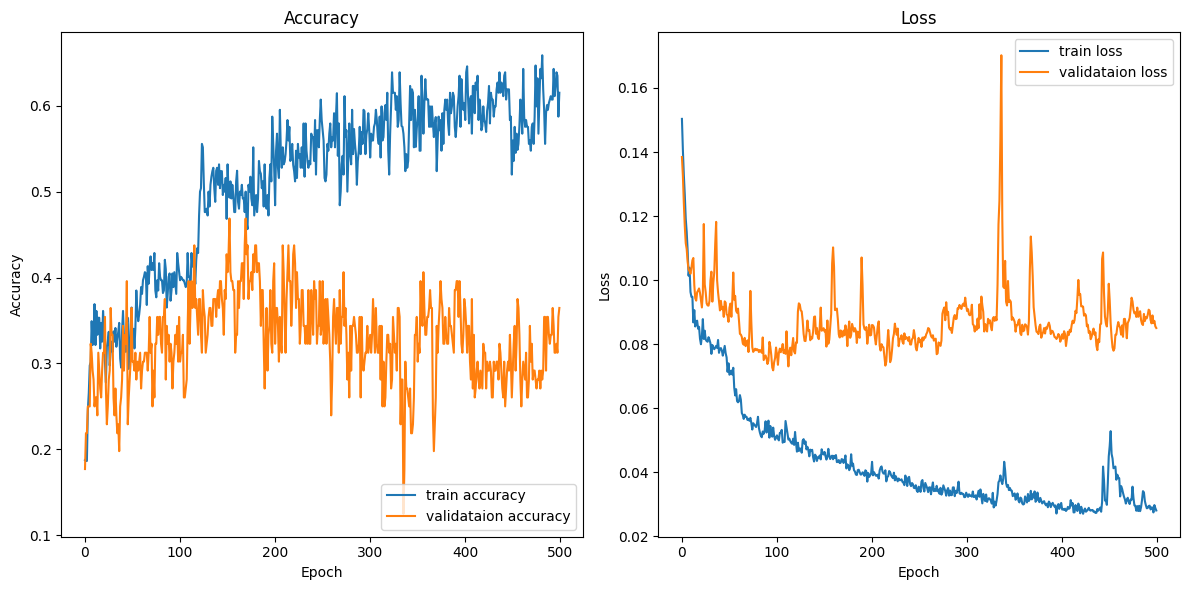

In [25]:
# Display learning curves
display_learning_curves(history)

Accuracy is (as shown on the left image) in both the training of the model, and the validation after training. Big gaps demonstrated, are linked to the overfitting due to lacking variety of ratings in the dataset. As epochs, keep going the validation accuracy stabilizes to the average we're obtaining from the model.

Right side, shows the loss of data per each epoch. Similarly loss stabilizes when doing the validation of the training.


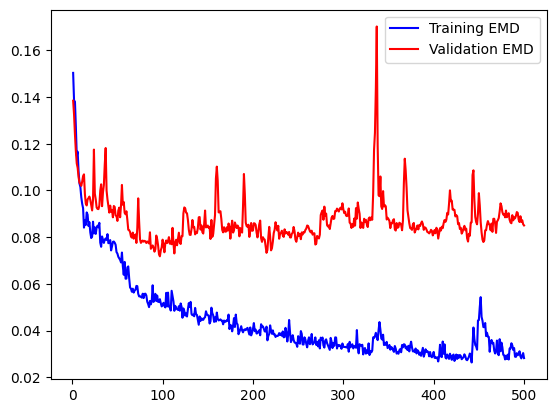

In [26]:
# Displaying learning curve


emd = history.history["earth_mover_loss"]
val_emd = history.history["val_earth_mover_loss"]

epochs_x = range(1, len(emd) + 1)

plt.plot(epochs_x, emd, 'b', label='Training EMD')
plt.plot(epochs_x, val_emd, 'r', label='Validation EMD')

plt.legend()

Earth's mover loss, is a more specific way of calculating that loss of the data, because is the one that descrribes the distribution of the predicted data against real data.

In [27]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [28]:
# To predict scores on the first 10 images
predictions = []

X_val = X_val / 255.0

for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = model.predict(img)

  predictions.append(float(np.sum(pred[0] * score_values)))

gt_scores = np.array(gt_scores)
predictions = np.array(predictions)

1/1 [==============================] - 0s 22ms/step


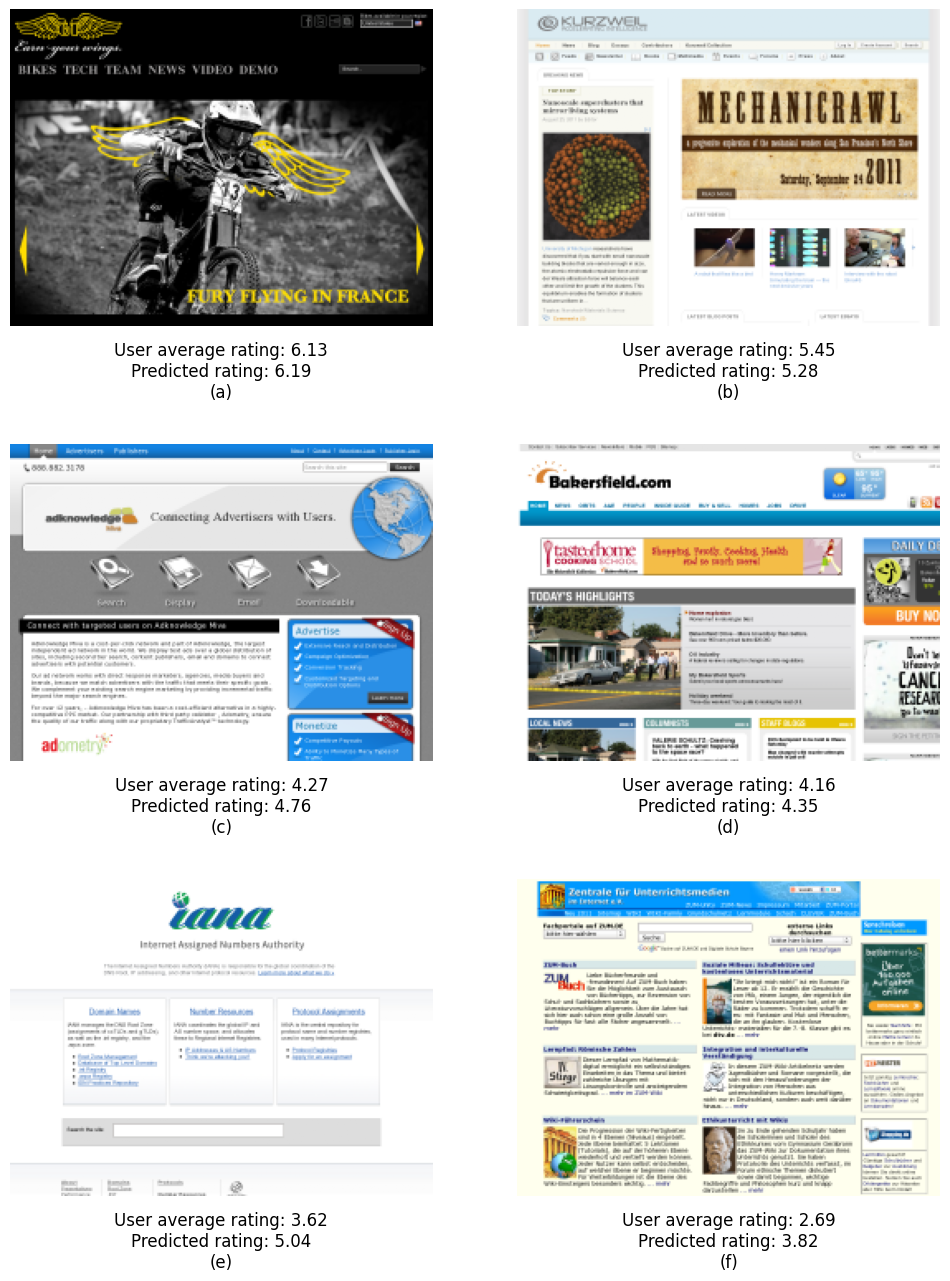

In [29]:
image_ids = [87, 45, 49, 94, 14, 83] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1]
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]

  plt.subplot(len(image_ids)//2, 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(gt_scores[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)

  i += 1

plt.show()

In last image we can appreciate how our model doesn't really cope well with low rating provided by user.



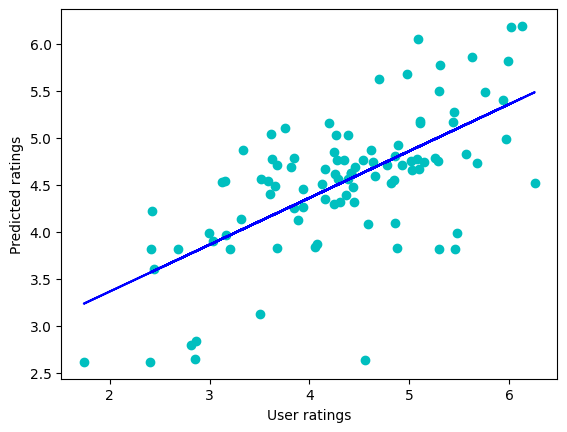

In [30]:
# Scatter plot for groundtruth and the predictions

from numpy.polynomial.polynomial import polyfit
b, m = polyfit(gt_scores, predictions, 1)

fig = plt.figure()
plt.scatter(gt_scores, predictions, c='c')
plt.plot(gt_scores, b + m * gt_scores, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

model's deviation

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

corr, p, lo, hi = pearsonr_ci(gt_scores, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(gt_scores, predictions))
print('RMSE: %.3f' % rmse_test)


Pearsons correlation: r=0.65, p=4.02e-13, CI=[0.52, 0.75]
RMSE: 0.761


<ipython-input-32-be61a24fe270>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gt_scores, bins=bins, label='User ratings')
<ipython-input-32-be61a24fe270>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions, bins=bins, label='Predicted ratings')


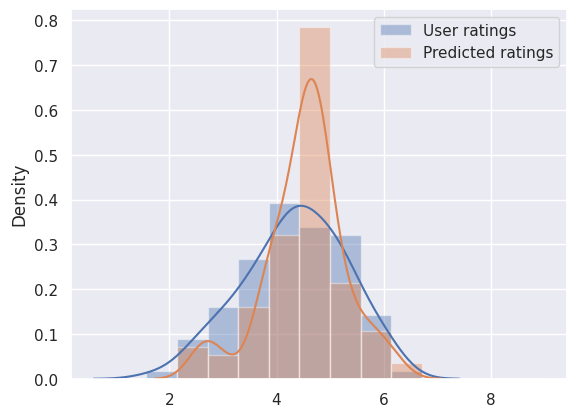

In [32]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(gt_scores, bins=bins, label='User ratings')

sns.distplot(predictions, bins=bins, label='Predicted ratings')

plt.legend()

plt.show()

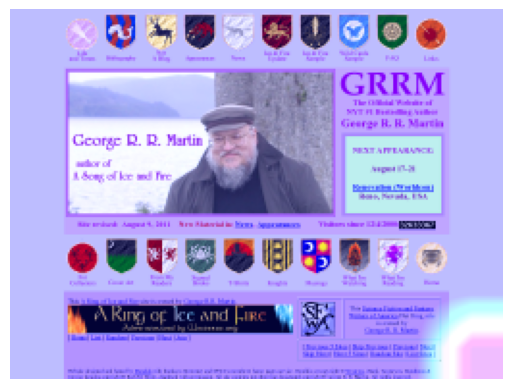

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_img_array(img_path, size):
    """Preprocess the image to get it ready for prediction"""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    """Generates a Grad-CAM heatmap for a given image and model"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Superimposes the heatmap on the original image and saves it"""
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    cv2.imwrite(cam_path, superimposed_img)
    return superimposed_img

juan = 22

# Ensure that the layer names match your model
last_conv_layer_name = 'conv_pw_13'
classifier_layer_names = ['global_average_pooling2d', 'dropout', 'dense', 'dense_1']

# Generate the Grad-CAM heatmap
img_array = get_img_array(all_images[juan], (192, 256))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Superimpose the heatmap on the original image
superimposed_img = save_and_display_gradcam(all_images[juan], heatmap)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


In [35]:
cd /usr/local/lib/python3.10/dist-packages/keras/src/engine

/usr/local/lib/python3.10/dist-packages/keras/src/engine


In [36]:
model.save('CalistaAestheticsMobileNet.keras')